# Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Data loading and splitting into train/test sets

In [2]:
def load_data(path, verbose=True):
    df = pd.read_csv(path, parse_dates=['birth_date', 'contact_date'])
    df_train = df.loc[df['y']!='unknown'].sample(frac=1, random_state=0)
    df_test = df.loc[df['y']=='unknown']
    X_train, y_train = df_train.drop(['y'], axis=1), (df_train['y']=='yes').astype(int)
    X_test = df_test.drop(['y'], axis=1)
    
    if verbose:
        print(f"X_train shape: {str(X_train.shape)}")
        print(f"X_test  shape: {str(X_test.shape)}")
        print(f"Training set has {100*y_train.mean():.2f}% of y=1 examples")
    
    return {"X_train": X_train, "y_train": y_train, "X_test": X_test}

data = load_data("data/bank-classification.csv")
data['X_train'].head()

X_train shape: (20799, 14)
X_test  shape: (20389, 14)
Training set has 11.44% of y=1 examples


,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome
40395,40396,1962-04-11,admin.,divorced,university.degree,no,no,no,2010-08-05,cellular,3,3,6,success
33240,33241,1977-09-10,entrepreneur,married,high.school,no,unknown,unknown,2009-05-12,cellular,1,999,0,nonexistent
10883,10884,1979-08-22,admin.,married,high.school,no,no,yes,2008-06-04,telephone,8,999,0,nonexistent
18517,18518,1955-04-15,blue-collar,married,basic.4y,unknown,no,no,2008-07-10,cellular,1,999,0,nonexistent
8404,8405,1965-09-25,blue-collar,married,basic.4y,unknown,yes,no,2008-06-10,telephone,3,999,0,nonexistent


# Distribution of categorical features

count      20799
unique        12
top       admin.
freq        5284
Name: job, dtype: object
mode:  0    admin.
dtype: object
admin.           5284
blue-collar      4708
technician       3365
services         1995
management       1485
retired           874
entrepreneur      745
self-employed     699
housemaid         522
unemployed        496
student           444
unknown           182
Name: job, dtype: int64


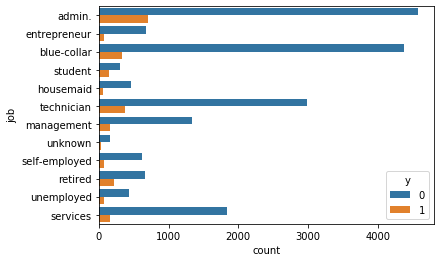

count        20799
unique           2
top       cellular
freq         13212
Name: contact, dtype: object
mode:  0    cellular
dtype: object
cellular     13212
telephone     7587
Name: contact, dtype: int64


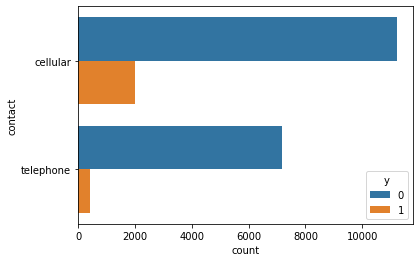

count       20799
unique          4
top       married
freq        12512
Name: marital, dtype: object
mode:  0    married
dtype: object
married     12512
single       5896
divorced     2347
unknown        44
Name: marital, dtype: int64


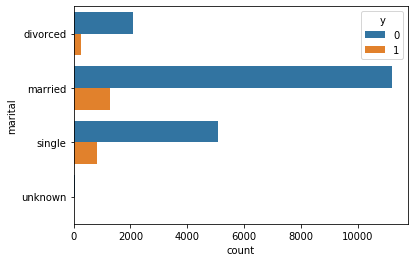

count                 20799
unique                    8
top       university.degree
freq                   6192
Name: education, dtype: object
mode:  0    university.degree
dtype: object
university.degree      6192
high.school            4781
basic.9y               3016
professional.course    2592
basic.4y               2154
basic.6y               1170
unknown                 887
illiterate                7
Name: education, dtype: int64


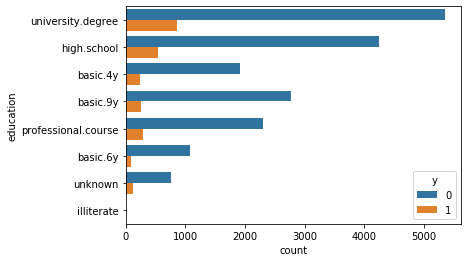

count     20799
unique        3
top          no
freq      16408
Name: default, dtype: object
mode:  0    no
dtype: object
no         16408
unknown     4389
yes            2
Name: default, dtype: int64


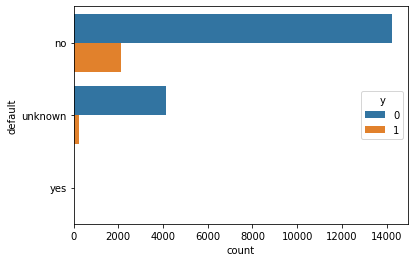

count     20799
unique        3
top         yes
freq      10923
Name: housing, dtype: object
mode:  0    yes
dtype: object
yes        10923
no          9386
unknown      490
Name: housing, dtype: int64


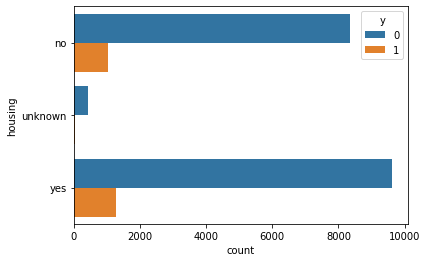

count     20799
unique        3
top          no
freq      17122
Name: loan, dtype: object
mode:  0    no
dtype: object
no         17122
yes         3187
unknown      490
Name: loan, dtype: int64


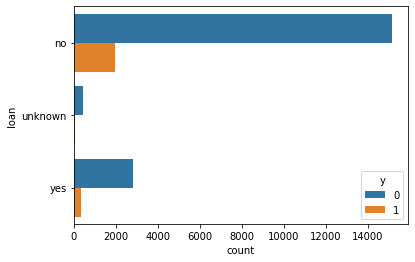

count           20799
unique              3
top       nonexistent
freq            17983
Name: poutcome, dtype: object
mode:  0    nonexistent
dtype: object
nonexistent    17983
failure         2143
success          673
Name: poutcome, dtype: int64


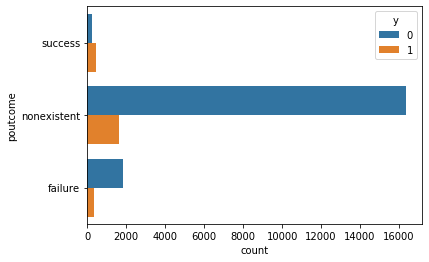

In [3]:
def categorical_summarized(df, y=None, hue=None, verbose=True):
    series = df[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*30)
        print(series.value_counts())
    sns.countplot(y=y, hue=hue, data=df, palette=['tab:blue', 'tab:orange'])
    plt.show()

categorical_features = ['job', 'contact', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
for feature in categorical_features:
    categorical_summarized(data['X_train'], y=feature, hue=data['y_train'])

# Distribution of numerical features

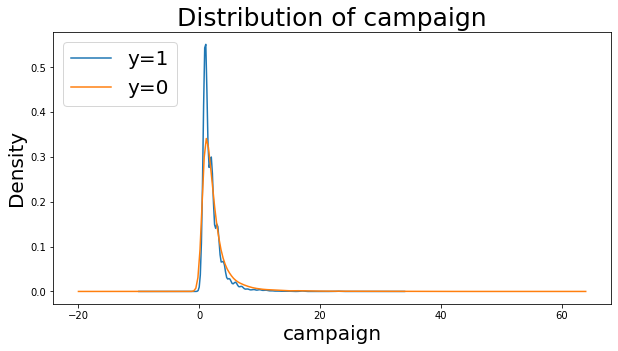

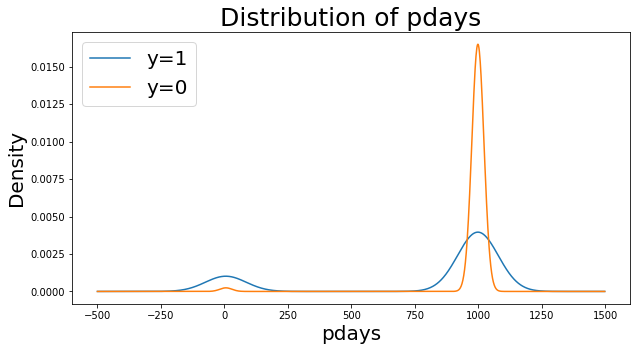

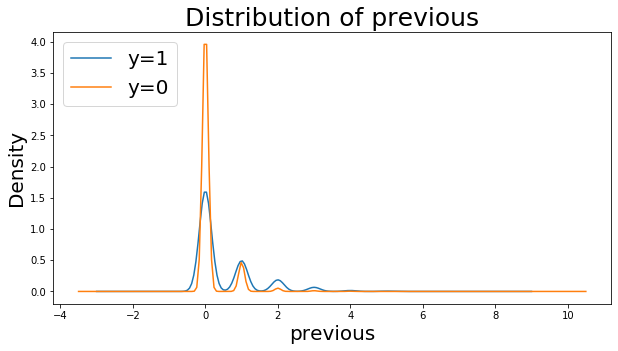

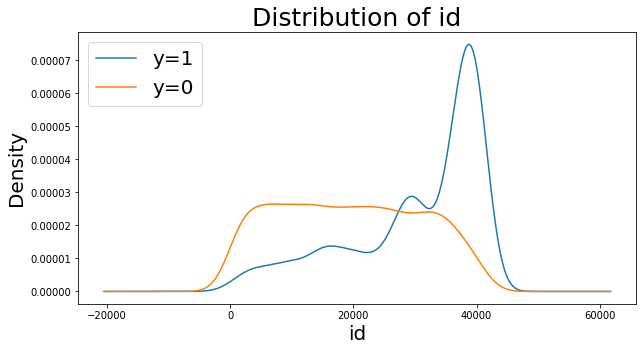

In [4]:
def numerical_densities(X, y, column):
    pos, neq = X.loc[y==1, column], X.loc[y==0, column]
    
    plt.figure(figsize=(10,5))
    pos.plot(kind='density', bw_method=0.2, ind=max(X[column])+200)
    neq.plot(kind='density', bw_method=0.2, ind=max(X[column])+200)
    plt.legend(['y=1', 'y=0'], loc='upper left', fontsize=20)
    plt.title(f"Distribution of {column}", fontsize=25)
    plt.xlabel(column, fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.show()
 
numerical_features = ['campaign', 'pdays', 'previous', 'id']
for col in numerical_features:
    numerical_densities(data['X_train'], data['y_train'], col)

# Data preparation

# Categorical data
- Dropping variables: default, marital, loan, education, housing since they didn't improved predictions. 
- For job feature I've created mapping corresponding to the distribution presented below.
- Additionaly I removed reduntant variables from get_dummies operations. 

In [5]:
def print_dist(df, col):
    countv = df[col].value_counts()
    count1 = df[col][data['y_train']==1].value_counts()
    print((count1/(countv+count1)).sort_values(ascending=False))
    
print_dist(data['X_train'], 'job')

student          0.247458
retired          0.195212
unemployed       0.120567
admin.           0.118010
unknown          0.116505
technician       0.100748
housemaid        0.100000
self-employed    0.096899
management       0.094512
entrepreneur     0.088127
services         0.074675
blue-collar      0.064574
Name: job, dtype: float64


In [6]:
def transform_categorical(df):
    X = df.copy()
    X = X[categorical_features]
    X = X.drop(['default', 'housing', 'education', 'loan', 'marital'], axis=1)
    
    replace_map = {
         'job': {'student': 1, 'retired': 2, 'unemployed': 3, 'admin.': 3, 'unknown': 3,
                   'technician': 4, 'housemaid': 4, 'self-employed': 5, 'management': 6,
                   'entrepreneur': 7, 'services': 8, 'blue-collar': 9
                }
    }
    
    X.replace(replace_map, inplace=True)
    X = pd.get_dummies(X)  
    X = X.drop(['contact_telephone', 'poutcome_failure'], axis=1)
    
    return X

X_cat=transform_categorical(data['X_train'])
X_cat.head()

,job,contact_cellular,poutcome_nonexistent,poutcome_success
40395,3,1,0,1
33240,7,1,1,0
10883,3,0,1,0
18517,9,1,1,0
8404,9,0,1,0


# Date
- Creating variables: 
    - days passed since contact_date
    - month of contact_date (maper created in similar manaer as for job)

I've also tried adding variables like age, day of week, day of month, year but they didn't improve predictions

In [7]:
def transform_date(df):
    X = df.copy() 
    cdate = X['contact_date']
    bdate = X['birth_date']
    
    df_date = pd.DataFrame(
        {
         'cdays_elapsed': ((max(cdate)-cdate)/(3*np.timedelta64(1, 'D'))).astype(int),
         'month': cdate.dt.month, 
        }) 

    df_date['month'].replace({12:1, 3:2, 10:3, 9:3, 4:4, 8:5, 6:5, 11:5, 7:6, 5:7}, inplace=True)

    return df_date

X_date=transform_date(data['X_train'])
X_date.head()

,cdays_elapsed,month
40395,39,5
33240,189,7
10883,303,5
18517,291,6
8404,301,5


# Some util functions for testing models

In [29]:
def plot_importance(model):
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
def cross_val(model, cv=4):
    cv_results=cross_validate(model, X_train, data['y_train'], scoring='roc_auc', cv=cv, n_jobs=-1)
    print(f"CV AUC = {np.mean(cv_results['test_score'])}")
    
def predict(model, verbose=True):
    model.fit(X_train, data['y_train'])
    y_pred = model.predict_proba(X_test)
    if verbose:
        plot_importance(model)
    return np.array(y_pred[:,1])

def prepare_submit(preds, name):
    data = {'id': X_test.index.values+1, 'y': preds.tolist()}
    df = pd.DataFrame(data)
    df.to_csv(name, index=False)
          
def prepare_data(df):
    df_cat = transform_categorical(df)
    df_date = transform_date(df)
    df_num = df[['pdays', 'campaign', 'id']]
    df_num = df_num.assign(campaign=df_num['campaign'] // 3, pdays=df_num['pdays'] // 5, id=df_num['id'] // 3)
    df_transf = pd.concat([df_cat, df_date, df_num], axis=1)
    return df_transf

def get_prepared_data(path):
    data = load_data(path, verbose=False)
    X_train, y_train, X_test = prepare_data(data['X_train']), data['y_train'], prepare_data(data['X_test'])
    return X_train, y_train, X_test

X_train, y_train, X_test = get_prepared_data("data/bank-classification.csv")
X_train.head()

,job,contact_cellular,poutcome_nonexistent,poutcome_success,cdays_elapsed,month,pdays,campaign,id
40395,3,1,0,1,39,5,0,1,13465
33240,7,1,1,0,189,7,199,0,11080
10883,3,0,1,0,303,5,199,2,3628
18517,9,1,1,0,291,6,199,0,6172
8404,9,0,1,0,301,5,199,1,2801


# Models definition

In [9]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=9, min_samples_leaf=6, class_weight="balanced",  random_state=0, n_jobs=-1)
gbm = GradientBoostingClassifier(n_estimators=139, learning_rate=0.04, max_depth=7, min_samples_leaf=10, subsample=0.69, random_state=0)
xgb = XGBClassifier(booster='gbtree', max_depth=6, learning_rate=0.07, max_delta_step=4, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, random_state=0)

# Evaluating models

In [30]:
cross_val(rfc)

CV AUC = 0.8051289990097301


In [31]:
cross_val(gbm)

CV AUC = 0.8041147335370726


In [32]:
cross_val(xgb)

CV AUC = 0.8010269970005734


# Feature importance plots

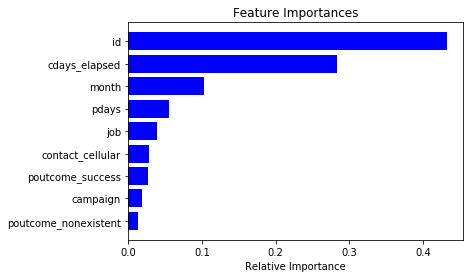

In [36]:
rfc_pred=predict(rfc)

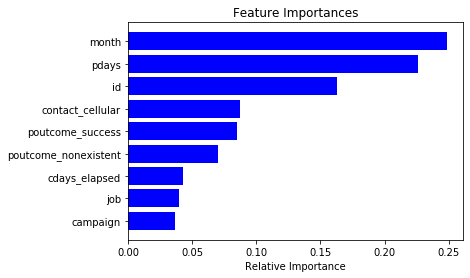

In [37]:
xgb_pred=predict(xgb)

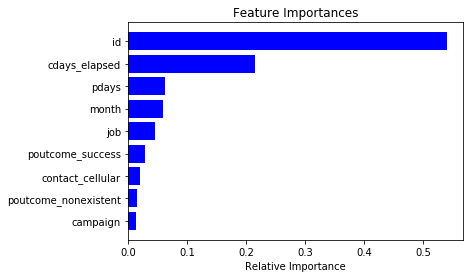

In [38]:
gbm_pred=predict(gbm)

# Final predictions

In [33]:
ensamble = np.mean([rfc_pred, xgb_pred, gbm_pred], axis=0)

In [34]:
prepare_submit(ensamble, 'ensamble.csv')

In [35]:
prepare_submit(gbm_pred, 'gbm.csv')